In [34]:
%matplotlib notebook
from tqdm import tqdm,trange
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import math
import statistics as stat
from matplotlib import pyplot as plt
import argparse


In [35]:
def crop_image(image):
    """
    promts user to select region of interest of the image
    
    input: image to crop
    
    output: 
    - cropped image
    - parameters of croping rectangle
    """
    r = cv2.selectROI(image)
    cropped = image[r[1]:(r[1]+r[3]),r[0]:(r[0]+r[2])]
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
    
    return cropped, r


def callback(x):
    """
    placeholder callback function
    """
    pass


def stack2x2(img0,img1,img2,img3):
    """
    stack 4 images 2x2
    
    input: 4 images to stack
    
    output: single image
    """
    try:
        return np.vstack([np.hstack([img0,img1]),np.hstack([img2,img3])])
    except:
        error_message = str(img0.shape)+str(img1.shape)+str(img2.shape)+str(img3.shape)
        raise NameError('PoEbaluNeHoschesh?\t'+error_message)


def adjust_parameres(cropped):
    """
    promts user to select parameters for the model
    
    input: calibration image
    output: 
    - gbkernel - kernel for gaussian blur
    - threshval - threshold value
    """
    
    interblur = cropped.copy()

    interthresh = cropped.copy()

    interedged = cropped.copy()

    ellipsed = cropped.copy()

    result = stack2x2(interblur,interthresh,interedged,ellipsed)

    # Create window
    cv2.namedWindow('trying gui')
    # Show an image in the window
    cv2.imshow('trying gui', result)
    # Add a slider
    cv2.createTrackbar('Blur', 'trying gui', 1, 254, callback)
    cv2.createTrackbar('Threshold', 'trying gui', 1, 255, callback)

    # create switch for ON/OFF functionality
    # switch = '0 : OFF \n1 : ON'
    # cv2.createTrackbar(switch, 'trying gui',0,1,callback)

    while(True):
        # Stack all operations together
        result = stack2x2(interblur,interthresh,interedged,ellipsed)
        # Show 'em
        cv2.imshow('trying gui',result)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        gbkernel = cv2.getTrackbarPos('Blur','trying gui')
        threshval = cv2.getTrackbarPos('Threshold','trying gui')

        # Gaussian Blur requires odd number, correct for it
        if gbkernel % 2 == 0:
            gbkernel = gbkernel + 1

        interblur,interthresh,interedged,contours,ellipses,ellipsed,target_id = find_pupil(cropped,gbkernel,threshval)

    cv2.destroyAllWindows()
    
    return gbkernel,threshval



In [36]:
def find_pupil(cropped,gbkernel,threshval):
    
    interblur = cv2.GaussianBlur(cropped.copy(),(gbkernel,gbkernel),0)
    _, interthresh = cv2.threshold(interblur.copy(),threshval,255,cv2.THRESH_BINARY)
    interedged = cv2.Canny(interthresh.copy(),100,200)
    
    _, contours, _ = cv2.findContours(interedged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    interedged = cv2.cvtColor(interedged,cv2.COLOR_GRAY2RGB);
        
        # Ellipse could only be fitted into a contour if it has at least 5 points. Thats why >4.
    contours = [contour for contour in contours if len(contour)>4]
        
        # Get rid of obviously too small as well as too big contours.
    contours = [contour for contour in contours if (cv2.contourArea(contour) > 200) & (cv2.contourArea(contour) < 17000)]
        
        # Fit an ellipse into previously filtered contours.
    ellipses = [cv2.fitEllipse(contour) for contour in contours]
        
        # Compute perimeter/area ratio of both original contours as well as fitted ellipses.
        # If area is 0, assign arbitrary high value.
        # Thus, we are defining the most "circular" out of all the fitted ellipses.
        #
        
    #loss = np.asarray([cv2.arcLength(cnt,True)/cv2.contourArea(cnt) if cv2.contourArea(cnt)!=0 else 100500 for cnt in contours])
    
    
    loss = np.asarray([abs(1-ellipse[1][0]/ellipse[1][1]) for ellipse in ellipses])
    
    #loss2 = np.asarray([(math.pi*((3*(ellipses[0][1][0] + ellipses[0][1][1])/2) - math.sqrt((3*ellipses[0][1][0]+ellipses[0][1][1])*(ellipses[0][1][0]+3*ellipses[0][1][1])/2)))/(math.pi / 4 * ellipses[0][1][0] * ellipses[0][1][1]) for x in ellipses])
        
        # Find the index of the minimal element of these perimeter/area ratios and pick the closest to a circle ellipse.
        # If ellipse has a better ratio, than math is on our side.
        # If not, we pray for the best by picking contour with a better ratio.
        # This was implemented to minimize the probability of chosing wrong ellipse.
    target_id = 0 #wtf?
    if loss.size != 0:    
        target_id = np.argmin(loss)
        
        # Draw an ellipse on the cropped image.
        ellipsed = cv2.ellipse(cropped.copy(),ellipses[target_id],(0,255,0),2)
    else:
        ellipsed = cropped.copy()

    return interblur,interthresh,interedged,contours,ellipses,ellipsed,target_id


In [49]:
eps = 0.20

In [38]:

filename = 'toy_data/3292_19-Jan-2016.mj2'
cap = cv2.VideoCapture(filename,0)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Test for crop. Will be used later in code to crop the eye region.
selection_set = False

    #since we know the lenght of video we can init the size of arrays 

pupil_area = np.zeros(length)
pupil_center = np.zeros([length,2])

    # Start the processing. The while loop iterates over all the frames in given data set one by one.
for i in trange(length):    
        
        # load the first frame
    _, frame = cap.read()
        
        # Select the eye region on the first frame.
    if not selection_set:
        cropped,r = crop_image(frame)

            #init placeholders for precessed images

        interblur = cropped.copy()
        interthresh = cropped.copy()

        interedged = cropped.copy()
        ellipsed = cropped.copy()
            
        gbkernel,threshval = adjust_parameres(cropped)
            
        selection_set = True
        
        
        # Crop the frame according to region selected in the beginning.
    cropped = frame[r[1]:(r[1]+r[3]),r[0]:(r[0]+r[2])]
        
    interblur,interthresh,interedged,contours,ellipses,ellipsed,target_id = find_pupil(cropped,gbkernel,threshval)
        
    result = stack2x2(interblur,interthresh,interedged,ellipsed)

    try:
        center, axes, _ = ellipses[target_id]
        
        if abs(1-axes[0]/axes[1]) > eps:
            pupil_area[i] = 0
            pupil_center[i][0] = 0
            pupil_center[i][1] = 0
            
            cv2.putText(result,"KVADRATURA EBA",(10,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(0,0,255),1,cv2.LINE_AA)
            
        else:
            ellarea = math.pi / 4 * axes[0] * axes[1]
            pupil_area[i] = ellarea
            pupil_center[i][0] = center[0]+r[0]
            pupil_center[i][1] = center[1]+r[3]
            
            cv2.putText(result,'Area: '+str(pupil_area[i]),(10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,170),1,cv2.LINE_AA)
            cv2.putText(result,'Center: '+str(pupil_center[i][0])+' '+str(pupil_center[i][1]),(10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,170),1,cv2.LINE_AA)
    
    except:
        pupil_area[i] = 0
        pupil_center[i][0] = 0
        pupil_center[i][1] = 0

        cv2.putText(result,"BLINK",(10,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(0,0,255),1,cv2.LINE_AA)



        # Pop-up all four steps 
    #cv2.imshow('result',result)
        
        # To stop video press q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        np.save('3292_19-Jan-2016_area',pupil_area)
        np.save('3292_19-Jan-2016_center',pupil_center)
        break

cap.release()
cv2.destroyAllWindows()



100%|████████████████████████████████████████████████████████████████████████████| 15963/15963 [04:27<00:00, 59.73it/s]


In [ ]:
if abs(1-axes[0]/axes[1]) > eps:
    pupil_area[i] = 0
    pupil_center[i][0] = 0
    pupil_center[i][1] = 0
            
    cv2.putText(result,"KVADRATURA EBA",(10,60), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(0,0,255),1,cv2.LINE_AA)

else:
    ellarea = math.pi / 4 * axes[0] * axes[1]
    pupil_area[i] = ellarea
    pupil_center[i][0] = center[0]+r[0]
    pupil_center[i][1] = center[1]+r[3]
            
    cv2.putText(result,'Area: '+str(pupil_area[i]),(10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,170),1,cv2.LINE_AA)
    cv2.putText(result,'Center: '+str(pupil_center[i][0])+' '+str(pupil_center[i][1]),(10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,170),1,cv2.LINE_AA)
    

In [42]:
area = np.load('3292_19-Jan-2016_area.npy')


In [43]:
len(area)

15963

In [45]:
pupil_area

array([    0.        ,     0.        ,     0.        , ...,  1453.37879376,
        1601.34972985,  1787.03140492])

<IPython.core.display.Javascript object>


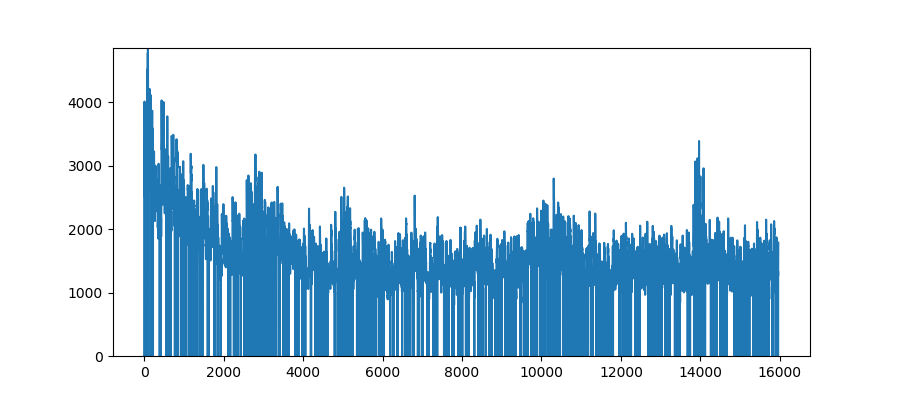

In [48]:
plt.figure(figsize=(9,4))
plt.ylim(0,np.max(pupil_area))
plt.plot(pupil_area)

In [24]:
cap.release()
cv2.destroyAllWindows()